In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import numpy as np
import tensorflow.keras
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical

In [2]:
transcripts_train = pd.read_csv("train.csv")

In [3]:
def load_wav_file(filename):
    file = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1).numpy()
    sample_rate = sample_rate.numpy()
    wav = librosa.resample(wav, orig_sr=sample_rate, target_sr=12000)
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    return wav

In [4]:
def preprocess(file):
    wav = load_wav_file(file)
    wav = wav[:70_000]
    zero_padding = tf.zeros([70_000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectogram = tf.signal.stft(wav, frame_length=400, frame_step=220)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    return spectogram

In [5]:
data = []
thres_train = 15000
test = []

for i in range(len(os.listdir("train"))):
    path = os.path.join("train", f"{transcripts_train['audio'][i]}.wav")
    data.append((preprocess(path), f"{transcripts_train['transcript'][i]}", i))
    if i == thres_train:
        break

for i in range(len(os.listdir("test"))):
    path = os.path.join("test", os.listdir("test")[i])
    test.append((preprocess(path), os.listdir("test")[i]))

size_data = tuple(data[0][0].shape)
num_classes_train = thres_train + 1

size_test = tuple(test[0][0].shape)

In [6]:
size_test

(317, 257, 1)

In [7]:
model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=size_data),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(num_classes_train, activation="softmax")
    ]
)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])
model.summary()

C:\Users\PC-ORBIT\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 315, 255, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 157, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 155, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 77, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 305536)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    19,554,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │         1,717 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,577,509 (74.68 MB)

 Trainable params: 19,577,509 (74.68 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
X_train = []
y_train = []
for d in data:
    X_train.append(d[0])
    y_train.append(d[2])

X_test = []
for d in test:
    X_test.append(d[0])

In [10]:
X_train = np.array(X_train).reshape(-1, *size_data)
X_test = np.array(X_test).reshape(-1, *size_test)

In [11]:
encoded_data = np.array(y_train)

In [12]:
encoded_data = to_categorical(encoded_data, num_classes=num_classes_train)

In [14]:
print(encoded_data.shape)
print(X_train.shape)
print(X_test.shape)

(101, 101)
(101, 317, 257, 1)
(6, 6)
(6, 317, 257, 1)
(1726, 317, 257, 1)


In [15]:
model_history = model.fit(X_train, encoded_data, epochs=2, batch_size=52)

Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 8s/step - accuracy: 0.0326 - loss: 4.9219 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.0130 - loss: 4.7562 - precision: 0.0000e+00 - recall: 0.0000e+00


In [17]:
prediction = model.predict(X_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step


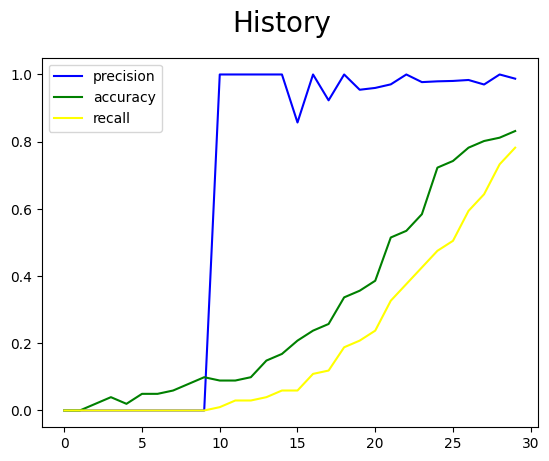

In [16]:
fig = plt.figure()
plt.plot(model_history.history["precision"], color='blue', label="precision")
plt.plot(model_history.history["accuracy"], color='green', label="accuracy")
plt.plot(model_history.history["recall"], color='yellow', label="recall")
fig.suptitle("History", fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [37]:
all_predicted = {}
for i in range(len(prediction)):
    all_predicted[test[i][1]] = data[np.argmax(prediction[i])][1]

In [41]:
import csv

with open("results.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(["audio", "transcript"])
    
    for key, value in all_predicted.items():
        writer.writerow([key, value])

In [ ]:
model.save("./mtc_comp/model.keras")